In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ambiance import Atmosphere

In [2]:
def gravity_acceleration(altitude,
                          g0=9.80, # m/s^2
                          R = 6.361e6 # m
                         ):
    return g0 * (R / (R + altitude)) ** 2

In [3]:
rho_f = lambda h: Atmosphere(h).density[0]

In [4]:
# create a function of time and state
def state_function(
    t,state,
    m = 25,
    CdA = 0.01
):
    x,z,vx,vz = state
    aero_force = CdA * rho_f(z) * np.sqrt(vx**2 + vz**2) / 2 / m
    ax = - vx * aero_force
    az = - gravity_acceleration(z) - aero_force * vz
    return(np.array([vx,vz,ax,az]))
    

state_function(0,[0,9144,.1,0])

array([ 1.00000000e-01,  0.00000000e+00, -9.18081064e-07, -9.77188544e+00])

In [5]:
def mach_event(t,state):
    x,z,vx,vz = state
    sound_speed = Atmosphere(z).speed_of_sound[0]
    speed = np.linalg.norm([vx,vz])
    return speed - sound_speed
mach_event.terminal = True

def altitude_event(t,state):
    return state[1]
altitude_event.terminal = True

In [6]:
from scipy.integrate import solve_ivp

out = solve_ivp(
    state_function,
    t_span=(0,-55),
    y0=[0,9144,.1,0],
    max_step=1,
    events=[mach_event,altitude_event]
)

In [7]:
CdAs = np.linspace(0.01,0.05,500)
curves = {}
for CdA in CdAs:
    soln = solve_ivp(
        lambda t,y : state_function(t,y,CdA=CdA),
        t_span=(0,-55),
        y0=[0,9144,.1,0],
        max_step=1,
        events=[mach_event,altitude_event]
    )
    curves[CdA] = soln

Text(0, 0.5, 'Velocity (m/s)')

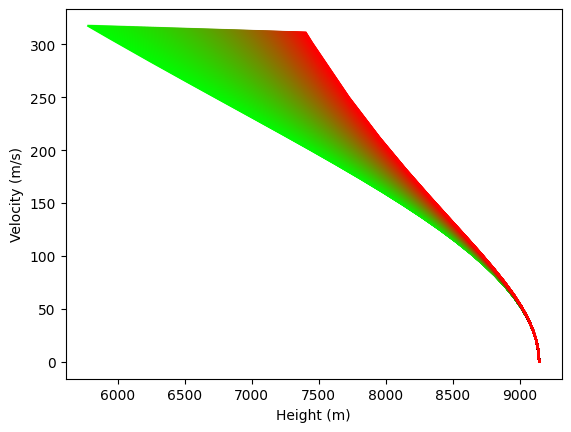

In [8]:
cmap = lambda CdA: ((CdA - 0.01)/0.04,1.-(CdA - 0.01)/0.04,0)
for CdA,curve in curves.items():
    plt.plot(curve['y'][1],curve['y'][3],color=cmap(CdA))
plt.xlabel('Height (m)')
plt.ylabel('Velocity (m/s)')

In [9]:
velocities = np.concatenate([soln['y'][3] for soln in curves.values()])
heights = np.concatenate([soln['y'][1] for soln in curves.values()])
cdas = np.concatenate([np.full(soln['y'][1].shape,cda) for cda,soln in curves.items()])

In [10]:
def cost(x):
    best_guess = x[5] * velocities**2 + x[4] * heights**2 + x[3] * velocities * heights + x[2] * velocities +  x[1] * heights + x[0]
    loss = cdas - best_guess
    cost = np.dot(loss,loss)
    return cost

In [11]:
from scipy.optimize import minimize
optim = minimize(cost,[0.1,1e-3,1e-2,1e-1,1e-4,1e-6])

In [12]:
optim

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 326018604117.51135
        x: [ 1.000e-01  9.896e-04  9.991e-03  6.301e-03 -6.080e-05
             1.680e-04]
      nit: 3
      jac: [ 2.057e+07  8.271e+10  1.426e+10  1.033e+14 -2.175e+12
             3.680e+12]
 hess_inv: [[ 1.000e+00 -1.912e-08 ... -1.179e-08 -2.555e-06]
            [-1.912e-08  1.000e+00 ... -1.087e-04 -8.890e-03]
            ...
            [-1.179e-08 -1.087e-04 ...  1.183e-08  9.668e-07]
            [-2.555e-06 -8.890e-03 ...  9.668e-07  8.003e-05]]
     nfev: 369
     njev: 51